## ETAPA B – Análisis de gastos (Desvío mensual contable)
### Proyecto: Automatización y análisis de gastos
### Autor: Dylan Anagua

### Este análisis va a tener 4 subetapas:
1.  Etapa B.1 - Grafico de pareto
2.	Etapa B.2 - Analisis de desvios respecto al periodo anterior
4.	Etapa B.3 - Interquartile Range (IQR)
5.  Etapa B.4 - Seleccion de cuentas adicionales

#### Las cuentas clasificadas como Pareto A (B.1) definen el universo relevante. Dentro de ese universo, solo aquellas con desvíos significativos o impacto material (B.2) avanzan a la Etapa B.3 para determinar que cuentas con desvíos atipicos requieren un análisis operacional.

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import date

#Formato para los importes
pd.options.display.float_format = '{:,.2f}'.format

#### Antes de comnezar con el analisis, se deben modificar las variables "mes" y "anio" con el periodo que se desea analizar. Formato:
1. mes: M
2. anio: AAAA

In [2]:
#VARIABLES A ACTUALIZAR
mes = 7
anio = 2024

In [3]:
ROOT = Path.cwd().parent
mayor_analisis = ROOT / "data" / "processed" / "mayor_analisis.csv"

#Funcion para obtener el periodo anterior analizado
def restar_mes(fecha: date) -> date:
    if fecha.month == 1:
        return date(fecha.year - 1, 12, 1)
    else:
        return date(fecha.year, fecha.month - 1, 1)

#Periodo actual
periodo_act = date(anio, mes, 1)
#Periodo anterior
periodo_ant = restar_mes(periodo_act)
 
print(periodo_act)
print(periodo_ant)


2024-07-01
2024-06-01


In [4]:
df: pd.DataFrame = pd.read_csv(mayor_analisis)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656789 entries, 0 to 656788
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   cod_cuenta      656789 non-null  int64  
 1   nombre_cuenta   656789 non-null  object 
 2   comprob         656789 non-null  object 
 3   numero          656789 non-null  int64  
 4   fecha           656789 non-null  object 
 5   sucursal        656789 non-null  int64  
 6   centro_costo    656789 non-null  int64  
 7   debe            656789 non-null  float64
 8   haber           656789 non-null  float64
 9   uni_neg         656789 non-null  int64  
 10  subuni_neg      656789 non-null  int64  
 11  nombre_negocio  656789 non-null  object 
 12  id_sector       656789 non-null  int64  
 13  cod_sector      608346 non-null  object 
 14  nombre_sector   608346 non-null  object 
 15  fecha_f         656789 non-null  object 
 16  proveedor       656789 non-null  int64  
 17  archivo_or

#### Se detectaron irregularidades en la descarga de distintos mayores desde el ERP, puntualmente en la columna fecha, es por eso que se procede a la normalizacion de la misma antes de realizar el analisis de la Etapa B.1

In [5]:
#Correcion de fechas

df["fecha"] = (
    df["fecha"]
    .astype(str)
    .str.strip()
    .str.replace(r"\s+00:00:00$", "", regex=True)
)

df["fecha"] = pd.to_datetime(df["fecha"])

#Creacion de una columna de valores aboslutos, a fin de analizar la significancia de las cuentas con importes acreedores 
df["importe_abs"] = df["importe"].abs()

#Creacion de un columna del periodo al que pertenece cada registro
df["periodo"] = df["fecha"].dt.strftime("%m/%Y")

#Dataset del mes bajo analisis
df_mes_act: pd.DataFrame = df[(df["fecha"].dt.month == periodo_act.month) & (df["fecha"].dt.year == periodo_act.year)]
#Dataset del mes anterior al analisis
df_mes_ant: pd.DataFrame = df[(df["fecha"].dt.month == periodo_ant.month) & (df["fecha"].dt.year == periodo_ant.year)]


### ETAPA B.1: Pareto mensual – Identificación de cuentas relevantes

##### Este análisis tiene como objetivo detectar cuentas significativas para un análisis posterior en la Etapa B.2, identificando aquellas que concentran la mayor proporción del gasto mensual. Este análisis busca responder que cuentas explican el gasto mensual del periodo analizado.
##### La clasificación es válida únicamente para el período analizado y se recalcula mes a mes.

In [6]:
#Dataset para realizar pareto
df_pareto = pd.DataFrame(df_mes_act.groupby(["cod_cuenta", "nombre_cuenta"], as_index=False).agg(importe=("importe", "sum"), importe_abs=("importe_abs", "sum")))
df_pareto


,cod_cuenta,nombre_cuenta,importe,importe_abs
0,6004,SUELDOS,"2,958,815,888.76","2,958,815,888.76"
1,6005,CARGAS SOCIALES,"956,791,451.24","969,597,806.32"
2,6006,HORAS EXTRAS,"76,923,273.14","76,923,273.14"
3,6007,SAC,"248,015,699.75","249,369,476.83"
4,6008,VACACIONES,"223,324,815.58","223,324,815.58"
...,...,...,...,...
116,6207,RENTA INVERSIONES,"-541,029,384.27","541,029,384.27"
117,6215,SERVICIO POR ENTREGA DE MERCADERIAS,"158,450,936.92","177,463,995.84"
118,6216,PEAJES AUTOMOTORES,"1,506,335.35","4,387,463.57"
119,6217,PEAJES UTILITARIOS,"1,613,573.06","6,715,326.38"


In [7]:
#Calculo del importe total de las cuentas de gastos en terminos absolutos
importe_total_abs = df_pareto["importe_abs"].sum()
print(f"El importe total para el periodo {periodo_act.month}/{periodo_act.year} es: {importe_total_abs}")

El importe total para el periodo 7/2024 es: 26905673699.5


In [8]:
#Orden de los importes, de mayor a menor y reset de index
df_pareto = df_pareto.sort_values("importe_abs", ascending=False).reset_index(drop=True)
df_pareto.head(10)

,cod_cuenta,nombre_cuenta,importe,importe_abs
0,6022,FLETES DE TERCEROS,"2,356,520,178.19","4,215,386,261.45"
1,6148,DIFERENCIAS DE CAMBIO,"42,826,060.98","3,152,655,238.16"
2,6004,SUELDOS,"2,958,815,888.76","2,958,815,888.76"
3,6108,IMPUESTO SOBRE LOS INGRESOS BRUTOS,"1,978,835,823.38","1,978,835,823.38"
4,6030,SERVICIO DE VIGILANCIA,"665,588,163.15","1,479,266,114.37"
5,6101,PUBLICIDAD EN GENERAL,"1,278,549,299.43","1,282,642,747.21"
6,6111,IMPUESTO A LOS DEBITOS Y CREDITOS BANCARIOS,"325,801,171.30","977,403,513.90"
7,6005,CARGAS SOCIALES,"956,791,451.24","969,597,806.32"
8,6185,RENTA FONDOS COMUNES DE INVERSION,"-321,109,079.28","878,913,282.16"
9,6074,MANTENIMIENTO E INSUMOS DE COMPUTACION,"-90,510,696.33","802,153,632.69"


In [9]:
#Columna calculada para obtener el valor relativo de participacion de cada cuenta respecto al importe total
df_pareto["pct_mes"] = (df_pareto["importe_abs"] / importe_total_abs) * 100
df_pareto

,cod_cuenta,nombre_cuenta,importe,importe_abs,pct_mes
0,6022,FLETES DE TERCEROS,"2,356,520,178.19","4,215,386,261.45",15.67
1,6148,DIFERENCIAS DE CAMBIO,"42,826,060.98","3,152,655,238.16",11.72
2,6004,SUELDOS,"2,958,815,888.76","2,958,815,888.76",11.00
3,6108,IMPUESTO SOBRE LOS INGRESOS BRUTOS,"1,978,835,823.38","1,978,835,823.38",7.35
4,6030,SERVICIO DE VIGILANCIA,"665,588,163.15","1,479,266,114.37",5.50
...,...,...,...,...,...
116,6141,GASTOS JUDICIALES,"267,210.00","267,210.00",0.00
117,6192,ESTACIONAMIENTO UTILITARIOS,"175,100.00","175,100.00",0.00
118,6070,FOTOCOPIAS,"127,525.00","127,525.00",0.00
119,6090,SEGUROS DE VIDA,"51,500.00","51,500.00",0.00


In [10]:
#Columna calculada para obtener el valor acumulado de participacion de cada cuenta respecto al importe total
df_pareto["pct_acumulado"] = df_pareto["pct_mes"].cumsum()
df_pareto

,cod_cuenta,nombre_cuenta,importe,importe_abs,pct_mes,pct_acumulado
0,6022,FLETES DE TERCEROS,"2,356,520,178.19","4,215,386,261.45",15.67,15.67
1,6148,DIFERENCIAS DE CAMBIO,"42,826,060.98","3,152,655,238.16",11.72,27.38
2,6004,SUELDOS,"2,958,815,888.76","2,958,815,888.76",11.00,38.38
3,6108,IMPUESTO SOBRE LOS INGRESOS BRUTOS,"1,978,835,823.38","1,978,835,823.38",7.35,45.74
4,6030,SERVICIO DE VIGILANCIA,"665,588,163.15","1,479,266,114.37",5.50,51.23
...,...,...,...,...,...,...
116,6141,GASTOS JUDICIALES,"267,210.00","267,210.00",0.00,100.00
117,6192,ESTACIONAMIENTO UTILITARIOS,"175,100.00","175,100.00",0.00,100.00
118,6070,FOTOCOPIAS,"127,525.00","127,525.00",0.00,100.00
119,6090,SEGUROS DE VIDA,"51,500.00","51,500.00",0.00,100.00


In [11]:

#Clasificacion de porcentajes acumulados en rangos
def clasificar_pareto(pct):
    if pct <= 80:
        return "A"
    elif pct <= 95:
        return "B"
    else:
        return "C"

df_pareto["clase_pareto"] = df_pareto["pct_acumulado"].apply(clasificar_pareto)
df_pareto

,cod_cuenta,nombre_cuenta,importe,importe_abs,pct_mes,pct_acumulado,clase_pareto
0,6022,FLETES DE TERCEROS,"2,356,520,178.19","4,215,386,261.45",15.67,15.67,A
1,6148,DIFERENCIAS DE CAMBIO,"42,826,060.98","3,152,655,238.16",11.72,27.38,A
2,6004,SUELDOS,"2,958,815,888.76","2,958,815,888.76",11.00,38.38,A
3,6108,IMPUESTO SOBRE LOS INGRESOS BRUTOS,"1,978,835,823.38","1,978,835,823.38",7.35,45.74,A
4,6030,SERVICIO DE VIGILANCIA,"665,588,163.15","1,479,266,114.37",5.50,51.23,A
...,...,...,...,...,...,...,...
116,6141,GASTOS JUDICIALES,"267,210.00","267,210.00",0.00,100.00,C
117,6192,ESTACIONAMIENTO UTILITARIOS,"175,100.00","175,100.00",0.00,100.00,C
118,6070,FOTOCOPIAS,"127,525.00","127,525.00",0.00,100.00,C
119,6090,SEGUROS DE VIDA,"51,500.00","51,500.00",0.00,100.00,C


In [12]:
print(f"Se filtra por el rango acumulado  que representan el 80% de la magnitud económica del período (en valores absolutos) {periodo_act.month}/{periodo_act.year}")
df_pareto[df_pareto["clase_pareto"] == "A"]

Se filtra por el rango acumulado  que representan el 80% de la magnitud económica del período (en valores absolutos) 7/2024


,cod_cuenta,nombre_cuenta,importe,importe_abs,pct_mes,pct_acumulado,clase_pareto
0,6022,FLETES DE TERCEROS,"2,356,520,178.19","4,215,386,261.45",15.67,15.67,A
1,6148,DIFERENCIAS DE CAMBIO,"42,826,060.98","3,152,655,238.16",11.72,27.38,A
2,6004,SUELDOS,"2,958,815,888.76","2,958,815,888.76",11.00,38.38,A
3,6108,IMPUESTO SOBRE LOS INGRESOS BRUTOS,"1,978,835,823.38","1,978,835,823.38",7.35,45.74,A
4,6030,SERVICIO DE VIGILANCIA,"665,588,163.15","1,479,266,114.37",5.50,51.23,A
5,6101,PUBLICIDAD EN GENERAL,"1,278,549,299.43","1,282,642,747.21",4.77,56.00,A
6,6111,IMPUESTO A LOS DEBITOS Y CREDITOS BANCARIOS,"325,801,171.30","977,403,513.90",3.63,59.63,A
7,6005,CARGAS SOCIALES,"956,791,451.24","969,597,806.32",3.60,63.24,A
8,6185,RENTA FONDOS COMUNES DE INVERSION,"-321,109,079.28","878,913,282.16",3.27,66.50,A
9,6074,MANTENIMIENTO E INSUMOS DE COMPUTACION,"-90,510,696.33","802,153,632.69",2.98,69.49,A


##### Grafico de Pareto

1. De este grafico se visualizan las principales cuentas que conforman la magnitud economica en terminos absolutos
2. Las cuentas que pertenecen a la clase "A", van a ser usadas para la Etapa B.2 del analisis 

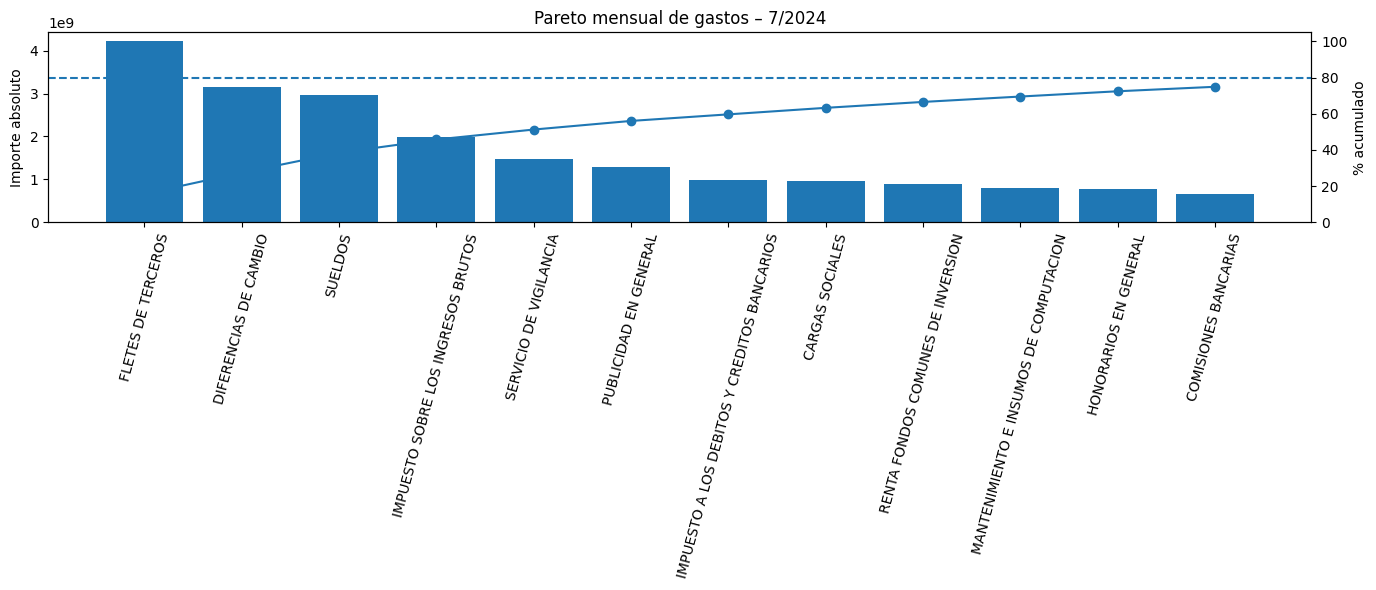

In [13]:
# Top N cuentas por magnitud
top_n = 12
df_plot = (
    df_pareto
        .sort_values("importe_abs", ascending=False)
        .head(top_n)
        .copy()
)

fig, ax1 = plt.subplots(figsize=(14, 6))

# Barras: importe absoluto
ax1.bar(
    df_plot["nombre_cuenta"],
    df_plot["importe_abs"]
)
ax1.set_ylabel("Importe absoluto")
ax1.tick_params(axis="x", rotation=75)

# Segundo eje: porcentaje acumulado
ax2 = ax1.twinx()
ax2.plot(
    df_plot["nombre_cuenta"],
    df_plot["pct_acumulado"],
    marker="o"
)
ax2.set_ylabel("% acumulado")

# Línea de referencia 80%
ax2.axhline(80, linestyle="--")
ax2.set_ylim(0, 105)

plt.title(f"Pareto mensual de gastos – {mes}/{anio}")
plt.tight_layout()
plt.show()

### Etapa B.2 - Deteccion de las cuentas con desvios significativos 

##### Este análisis tiene como objetivo detectar aquellas cuentas con desvios significativos. La metodologia para considerar como desvío significativo a una cuenta es la siguiente:

1. Impacto total mayor a 10%
2. Desvio mensual de 20%

##### Las cuentas que cumplan con la metodologia estblecida, van a usarse para la etapa B.3 y asi poder aplicar la politica de desvios.


In [14]:
#Datasets del periodo acttual y anterior
df_act = pd.DataFrame(df_mes_act.groupby(["cod_cuenta", "nombre_cuenta", "periodo"], as_index=False).agg(importe_act=("importe", "sum"), importe_abs_act=("importe_abs", "sum")))
df_ant = pd.DataFrame(df_mes_ant.groupby(["cod_cuenta", "nombre_cuenta", "periodo"], as_index=False).agg(importe_ant=("importe", "sum"), importe_abs_ant=("importe_abs", "sum")))

In [15]:
#Combiancion del dataset del periodo analizado y el periodo anterior
df_comp = df_act.merge(
    df_ant,
    on=["cod_cuenta", "nombre_cuenta"],
    how="outer"
    ).fillna(0)
df_comp = df_comp.rename(columns={"periodo_x" : "periodo_act", "periodo_y" : "periodo_ant"})
df_comp

,cod_cuenta,nombre_cuenta,periodo_act,importe_act,importe_abs_act,periodo_ant,importe_ant,importe_abs_ant
0,6004,SUELDOS,07/2024,"2,958,815,888.76","2,958,815,888.76",06/2024,"2,926,632,270.97","2,926,632,270.97"
1,6005,CARGAS SOCIALES,07/2024,"956,791,451.24","969,597,806.32",06/2024,"995,152,847.24","6,927,550,060.24"
2,6006,HORAS EXTRAS,07/2024,"76,923,273.14","76,923,273.14",06/2024,"55,046,706.34","55,046,706.34"
3,6007,SAC,07/2024,"248,015,699.75","249,369,476.83",06/2024,"328,912,570.59","2,509,773,811.97"
4,6008,VACACIONES,07/2024,"223,324,815.58","223,324,815.58",06/2024,"253,663,862.84","253,663,862.84"
...,...,...,...,...,...,...,...,...
117,6207,RENTA INVERSIONES,07/2024,"-541,029,384.27","541,029,384.27",06/2024,"-2,497,412,146.77","2,497,412,146.77"
118,6215,SERVICIO POR ENTREGA DE MERCADERIAS,07/2024,"158,450,936.92","177,463,995.84",06/2024,"315,916,123.42","315,916,123.42"
119,6216,PEAJES AUTOMOTORES,07/2024,"1,506,335.35","4,387,463.57",06/2024,"2,230,534.48","7,427,006.84"
120,6217,PEAJES UTILITARIOS,07/2024,"1,613,573.06","6,715,326.38",06/2024,"3,702,893.90","9,945,197.42"


In [16]:
#Variacion mensual de las cuentas relevantes del periodo

df_comp["variacion_abs"] = df_comp["importe_abs_act"] - df_comp["importe_abs_ant"]
df_comp

,cod_cuenta,nombre_cuenta,periodo_act,importe_act,importe_abs_act,periodo_ant,importe_ant,importe_abs_ant,variacion_abs
0,6004,SUELDOS,07/2024,"2,958,815,888.76","2,958,815,888.76",06/2024,"2,926,632,270.97","2,926,632,270.97","32,183,617.79"
1,6005,CARGAS SOCIALES,07/2024,"956,791,451.24","969,597,806.32",06/2024,"995,152,847.24","6,927,550,060.24","-5,957,952,253.92"
2,6006,HORAS EXTRAS,07/2024,"76,923,273.14","76,923,273.14",06/2024,"55,046,706.34","55,046,706.34","21,876,566.80"
3,6007,SAC,07/2024,"248,015,699.75","249,369,476.83",06/2024,"328,912,570.59","2,509,773,811.97","-2,260,404,335.14"
4,6008,VACACIONES,07/2024,"223,324,815.58","223,324,815.58",06/2024,"253,663,862.84","253,663,862.84","-30,339,047.26"
...,...,...,...,...,...,...,...,...,...
117,6207,RENTA INVERSIONES,07/2024,"-541,029,384.27","541,029,384.27",06/2024,"-2,497,412,146.77","2,497,412,146.77","-1,956,382,762.50"
118,6215,SERVICIO POR ENTREGA DE MERCADERIAS,07/2024,"158,450,936.92","177,463,995.84",06/2024,"315,916,123.42","315,916,123.42","-138,452,127.58"
119,6216,PEAJES AUTOMOTORES,07/2024,"1,506,335.35","4,387,463.57",06/2024,"2,230,534.48","7,427,006.84","-3,039,543.27"
120,6217,PEAJES UTILITARIOS,07/2024,"1,613,573.06","6,715,326.38",06/2024,"3,702,893.90","9,945,197.42","-3,229,871.04"


In [17]:
#Variacion relativa mensual de las cuentas relevantes del periodo

df_comp["variacion_pct"] = (df_comp["variacion_abs"]/df_comp["importe_abs_ant"].replace(0, pd.NA))*100
df_comp

,cod_cuenta,nombre_cuenta,periodo_act,importe_act,importe_abs_act,periodo_ant,importe_ant,importe_abs_ant,variacion_abs,variacion_pct
0,6004,SUELDOS,07/2024,"2,958,815,888.76","2,958,815,888.76",06/2024,"2,926,632,270.97","2,926,632,270.97","32,183,617.79",1.10
1,6005,CARGAS SOCIALES,07/2024,"956,791,451.24","969,597,806.32",06/2024,"995,152,847.24","6,927,550,060.24","-5,957,952,253.92",-86.00
2,6006,HORAS EXTRAS,07/2024,"76,923,273.14","76,923,273.14",06/2024,"55,046,706.34","55,046,706.34","21,876,566.80",39.74
3,6007,SAC,07/2024,"248,015,699.75","249,369,476.83",06/2024,"328,912,570.59","2,509,773,811.97","-2,260,404,335.14",-90.06
4,6008,VACACIONES,07/2024,"223,324,815.58","223,324,815.58",06/2024,"253,663,862.84","253,663,862.84","-30,339,047.26",-11.96
...,...,...,...,...,...,...,...,...,...,...
117,6207,RENTA INVERSIONES,07/2024,"-541,029,384.27","541,029,384.27",06/2024,"-2,497,412,146.77","2,497,412,146.77","-1,956,382,762.50",-78.34
118,6215,SERVICIO POR ENTREGA DE MERCADERIAS,07/2024,"158,450,936.92","177,463,995.84",06/2024,"315,916,123.42","315,916,123.42","-138,452,127.58",-43.83
119,6216,PEAJES AUTOMOTORES,07/2024,"1,506,335.35","4,387,463.57",06/2024,"2,230,534.48","7,427,006.84","-3,039,543.27",-40.93
120,6217,PEAJES UTILITARIOS,07/2024,"1,613,573.06","6,715,326.38",06/2024,"3,702,893.90","9,945,197.42","-3,229,871.04",-32.48


In [18]:
#Impacto total de cada cuenta respecto al desvio total producido en el mes analizado
desvio_total = df_comp["variacion_abs"].abs().sum()

df_comp["impacto_total"] = (df_comp["variacion_abs"].abs()/desvio_total)*100
df_comp

,cod_cuenta,nombre_cuenta,periodo_act,importe_act,importe_abs_act,periodo_ant,importe_ant,importe_abs_ant,variacion_abs,variacion_pct,impacto_total
0,6004,SUELDOS,07/2024,"2,958,815,888.76","2,958,815,888.76",06/2024,"2,926,632,270.97","2,926,632,270.97","32,183,617.79",1.10,0.20
1,6005,CARGAS SOCIALES,07/2024,"956,791,451.24","969,597,806.32",06/2024,"995,152,847.24","6,927,550,060.24","-5,957,952,253.92",-86.00,36.19
2,6006,HORAS EXTRAS,07/2024,"76,923,273.14","76,923,273.14",06/2024,"55,046,706.34","55,046,706.34","21,876,566.80",39.74,0.13
3,6007,SAC,07/2024,"248,015,699.75","249,369,476.83",06/2024,"328,912,570.59","2,509,773,811.97","-2,260,404,335.14",-90.06,13.73
4,6008,VACACIONES,07/2024,"223,324,815.58","223,324,815.58",06/2024,"253,663,862.84","253,663,862.84","-30,339,047.26",-11.96,0.18
...,...,...,...,...,...,...,...,...,...,...,...
117,6207,RENTA INVERSIONES,07/2024,"-541,029,384.27","541,029,384.27",06/2024,"-2,497,412,146.77","2,497,412,146.77","-1,956,382,762.50",-78.34,11.88
118,6215,SERVICIO POR ENTREGA DE MERCADERIAS,07/2024,"158,450,936.92","177,463,995.84",06/2024,"315,916,123.42","315,916,123.42","-138,452,127.58",-43.83,0.84
119,6216,PEAJES AUTOMOTORES,07/2024,"1,506,335.35","4,387,463.57",06/2024,"2,230,534.48","7,427,006.84","-3,039,543.27",-40.93,0.02
120,6217,PEAJES UTILITARIOS,07/2024,"1,613,573.06","6,715,326.38",06/2024,"3,702,893.90","9,945,197.42","-3,229,871.04",-32.48,0.02


In [19]:
#Se estable el listado de cuentas clasificadas como "A" en el analisis de pareto
cuentas_A = df_pareto.loc[df_pareto["clase_pareto"] == "A", "cod_cuenta"]

#Dataset flistrado por las cuentas relevantes a analizar
df_comp_A = df_comp[df_comp["cod_cuenta"].isin(cuentas_A)].copy()
df_comp_A



,cod_cuenta,nombre_cuenta,periodo_act,importe_act,importe_abs_act,periodo_ant,importe_ant,importe_abs_ant,variacion_abs,variacion_pct,impacto_total
0,6004,SUELDOS,07/2024,"2,958,815,888.76","2,958,815,888.76",06/2024,"2,926,632,270.97","2,926,632,270.97","32,183,617.79",1.10,0.20
1,6005,CARGAS SOCIALES,07/2024,"956,791,451.24","969,597,806.32",06/2024,"995,152,847.24","6,927,550,060.24","-5,957,952,253.92",-86.00,36.19
14,6022,FLETES DE TERCEROS,07/2024,"2,356,520,178.19","4,215,386,261.45",06/2024,"1,843,550,847.04","4,370,131,903.08","-154,745,641.63",-3.54,0.94
16,6024,GASTOS DE EMBALAJE,07/2024,"336,671,478.10","446,992,540.30",06/2024,"186,403,961.10","212,383,856.16","234,608,684.14",110.46,1.42
20,6030,SERVICIO DE VIGILANCIA,07/2024,"665,588,163.15","1,479,266,114.37",06/2024,"534,522,239.93","1,486,952,924.11","-7,686,809.74",-0.52,0.05
52,6074,MANTENIMIENTO E INSUMOS DE COMPUTACION,07/2024,"-90,510,696.33","802,153,632.69",06/2024,"206,468,373.20","256,794,956.76","545,358,675.93",212.37,3.31
58,6084,HONORARIOS EN GENERAL,07/2024,"729,871,778.47","783,875,873.41",06/2024,"593,303,210.80","685,995,901.68","97,879,971.73",14.27,0.59
68,6101,PUBLICIDAD EN GENERAL,07/2024,"1,278,549,299.43","1,282,642,747.21",06/2024,"800,335,811.09","838,461,738.77","444,181,008.44",52.98,2.70
70,6104,COMISIONES BANCARIAS,07/2024,"262,485,811.82","667,756,163.24",06/2024,"294,850,245.46","722,059,128.26","-54,302,965.02",-7.52,0.33
72,6108,IMPUESTO SOBRE LOS INGRESOS BRUTOS,07/2024,"1,978,835,823.38","1,978,835,823.38",06/2024,"1,403,324,990.14","1,403,324,990.14","575,510,833.24",41.01,3.50


##### Apliacion de la metodología para definir las cuentas con desvíos significativos

In [20]:
df_comp_A["flag_alerta"] = (
    (df_comp_A["impacto_total"] >= 10) |
    (df_comp_A["variacion_pct"].abs() >= 20))
df_comp_A

,cod_cuenta,nombre_cuenta,periodo_act,importe_act,importe_abs_act,periodo_ant,importe_ant,importe_abs_ant,variacion_abs,variacion_pct,impacto_total,flag_alerta
0,6004,SUELDOS,07/2024,"2,958,815,888.76","2,958,815,888.76",06/2024,"2,926,632,270.97","2,926,632,270.97","32,183,617.79",1.10,0.20,False
1,6005,CARGAS SOCIALES,07/2024,"956,791,451.24","969,597,806.32",06/2024,"995,152,847.24","6,927,550,060.24","-5,957,952,253.92",-86.00,36.19,True
14,6022,FLETES DE TERCEROS,07/2024,"2,356,520,178.19","4,215,386,261.45",06/2024,"1,843,550,847.04","4,370,131,903.08","-154,745,641.63",-3.54,0.94,False
16,6024,GASTOS DE EMBALAJE,07/2024,"336,671,478.10","446,992,540.30",06/2024,"186,403,961.10","212,383,856.16","234,608,684.14",110.46,1.42,True
20,6030,SERVICIO DE VIGILANCIA,07/2024,"665,588,163.15","1,479,266,114.37",06/2024,"534,522,239.93","1,486,952,924.11","-7,686,809.74",-0.52,0.05,False
52,6074,MANTENIMIENTO E INSUMOS DE COMPUTACION,07/2024,"-90,510,696.33","802,153,632.69",06/2024,"206,468,373.20","256,794,956.76","545,358,675.93",212.37,3.31,True
58,6084,HONORARIOS EN GENERAL,07/2024,"729,871,778.47","783,875,873.41",06/2024,"593,303,210.80","685,995,901.68","97,879,971.73",14.27,0.59,False
68,6101,PUBLICIDAD EN GENERAL,07/2024,"1,278,549,299.43","1,282,642,747.21",06/2024,"800,335,811.09","838,461,738.77","444,181,008.44",52.98,2.70,True
70,6104,COMISIONES BANCARIAS,07/2024,"262,485,811.82","667,756,163.24",06/2024,"294,850,245.46","722,059,128.26","-54,302,965.02",-7.52,0.33,False
72,6108,IMPUESTO SOBRE LOS INGRESOS BRUTOS,07/2024,"1,978,835,823.38","1,978,835,823.38",06/2024,"1,403,324,990.14","1,403,324,990.14","575,510,833.24",41.01,3.50,True


In [21]:
#Orden del dataset
df_comp_A = df_comp_A.sort_values("impacto_total", ascending=False).reset_index(drop=True)
df_comp_A

,cod_cuenta,nombre_cuenta,periodo_act,importe_act,importe_abs_act,periodo_ant,importe_ant,importe_abs_ant,variacion_abs,variacion_pct,impacto_total,flag_alerta
0,6005,CARGAS SOCIALES,07/2024,"956,791,451.24","969,597,806.32",06/2024,"995,152,847.24","6,927,550,060.24","-5,957,952,253.92",-86.00,36.19,True
1,6207,RENTA INVERSIONES,07/2024,"-541,029,384.27","541,029,384.27",06/2024,"-2,497,412,146.77","2,497,412,146.77","-1,956,382,762.50",-78.34,11.88,True
2,6185,RENTA FONDOS COMUNES DE INVERSION,07/2024,"-321,109,079.28","878,913,282.16",06/2024,"-278,902,101.44","1,536,443,940.28","-657,530,658.12",-42.80,3.99,True
3,6108,IMPUESTO SOBRE LOS INGRESOS BRUTOS,07/2024,"1,978,835,823.38","1,978,835,823.38",06/2024,"1,403,324,990.14","1,403,324,990.14","575,510,833.24",41.01,3.50,True
4,6074,MANTENIMIENTO E INSUMOS DE COMPUTACION,07/2024,"-90,510,696.33","802,153,632.69",06/2024,"206,468,373.20","256,794,956.76","545,358,675.93",212.37,3.31,True
5,6101,PUBLICIDAD EN GENERAL,07/2024,"1,278,549,299.43","1,282,642,747.21",06/2024,"800,335,811.09","838,461,738.77","444,181,008.44",52.98,2.70,True
6,6148,DIFERENCIAS DE CAMBIO,07/2024,"42,826,060.98","3,152,655,238.16",06/2024,"196,061,768.31","2,864,600,433.81","288,054,804.35",10.06,1.75,False
7,6024,GASTOS DE EMBALAJE,07/2024,"336,671,478.10","446,992,540.30",06/2024,"186,403,961.10","212,383,856.16","234,608,684.14",110.46,1.42,True
8,6140,COMISIONES,07/2024,"293,247,363.72","375,172,862.64",06/2024,"50,359,253.00","176,017,275.72","199,155,586.92",113.15,1.21,True
9,6022,FLETES DE TERCEROS,07/2024,"2,356,520,178.19","4,215,386,261.45",06/2024,"1,843,550,847.04","4,370,131,903.08","-154,745,641.63",-3.54,0.94,False


##### Cuentas que cumplen con la metodología de desvios

In [22]:
df_comp_A[df_comp_A["flag_alerta"] == True]

,cod_cuenta,nombre_cuenta,periodo_act,importe_act,importe_abs_act,periodo_ant,importe_ant,importe_abs_ant,variacion_abs,variacion_pct,impacto_total,flag_alerta
0,6005,CARGAS SOCIALES,07/2024,"956,791,451.24","969,597,806.32",06/2024,"995,152,847.24","6,927,550,060.24","-5,957,952,253.92",-86.00,36.19,True
1,6207,RENTA INVERSIONES,07/2024,"-541,029,384.27","541,029,384.27",06/2024,"-2,497,412,146.77","2,497,412,146.77","-1,956,382,762.50",-78.34,11.88,True
2,6185,RENTA FONDOS COMUNES DE INVERSION,07/2024,"-321,109,079.28","878,913,282.16",06/2024,"-278,902,101.44","1,536,443,940.28","-657,530,658.12",-42.80,3.99,True
3,6108,IMPUESTO SOBRE LOS INGRESOS BRUTOS,07/2024,"1,978,835,823.38","1,978,835,823.38",06/2024,"1,403,324,990.14","1,403,324,990.14","575,510,833.24",41.01,3.50,True
4,6074,MANTENIMIENTO E INSUMOS DE COMPUTACION,07/2024,"-90,510,696.33","802,153,632.69",06/2024,"206,468,373.20","256,794,956.76","545,358,675.93",212.37,3.31,True
5,6101,PUBLICIDAD EN GENERAL,07/2024,"1,278,549,299.43","1,282,642,747.21",06/2024,"800,335,811.09","838,461,738.77","444,181,008.44",52.98,2.70,True
7,6024,GASTOS DE EMBALAJE,07/2024,"336,671,478.10","446,992,540.30",06/2024,"186,403,961.10","212,383,856.16","234,608,684.14",110.46,1.42,True
8,6140,COMISIONES,07/2024,"293,247,363.72","375,172,862.64",06/2024,"50,359,253.00","176,017,275.72","199,155,586.92",113.15,1.21,True


### Etapa B.3 - Interquartile Range (IQR)

#### Este análisis se arma en funcion a la politica de desvios de gastos mensuales la cual estable que, salvo cuentas de gastos con analisis propios, el desvios de los gastos totales  de un periodo no pueden exceder el 20% sin una justificación y/o documentacion que explique tal desvío. A su vez, se establece que, todos las cuentas con desvios muy significativos deben ser anlizadas operativamente, incluso si el desvio total del periodo no supera el umbral del 20%.
#### En base a esto es que se establece el análisis mediante IQR que permite identificar las cuentas con desvios atípicos (outliers) dentro del conjunto que cumplio con la metodologia de desvios significativos (flag alert). Estas cuentas con variaciones que se desvían significativamente del comportamiento habitual del conjunto, son las que van a requirir un análisis operativo posterior para justificar dicho comportamiento.

In [23]:
#Dataset IQR
df_iqr: pd.DataFrame = df_comp_A.copy()

#Valor absoluto de la variacion total de cada cuenta
df_iqr["variacion_abs_val"] = df_iqr["variacion_abs"].abs()

df_iqr

,cod_cuenta,nombre_cuenta,periodo_act,importe_act,importe_abs_act,periodo_ant,importe_ant,importe_abs_ant,variacion_abs,variacion_pct,impacto_total,flag_alerta,variacion_abs_val
0,6005,CARGAS SOCIALES,07/2024,"956,791,451.24","969,597,806.32",06/2024,"995,152,847.24","6,927,550,060.24","-5,957,952,253.92",-86.00,36.19,True,"5,957,952,253.92"
1,6207,RENTA INVERSIONES,07/2024,"-541,029,384.27","541,029,384.27",06/2024,"-2,497,412,146.77","2,497,412,146.77","-1,956,382,762.50",-78.34,11.88,True,"1,956,382,762.50"
2,6185,RENTA FONDOS COMUNES DE INVERSION,07/2024,"-321,109,079.28","878,913,282.16",06/2024,"-278,902,101.44","1,536,443,940.28","-657,530,658.12",-42.80,3.99,True,"657,530,658.12"
3,6108,IMPUESTO SOBRE LOS INGRESOS BRUTOS,07/2024,"1,978,835,823.38","1,978,835,823.38",06/2024,"1,403,324,990.14","1,403,324,990.14","575,510,833.24",41.01,3.50,True,"575,510,833.24"
4,6074,MANTENIMIENTO E INSUMOS DE COMPUTACION,07/2024,"-90,510,696.33","802,153,632.69",06/2024,"206,468,373.20","256,794,956.76","545,358,675.93",212.37,3.31,True,"545,358,675.93"
5,6101,PUBLICIDAD EN GENERAL,07/2024,"1,278,549,299.43","1,282,642,747.21",06/2024,"800,335,811.09","838,461,738.77","444,181,008.44",52.98,2.70,True,"444,181,008.44"
6,6148,DIFERENCIAS DE CAMBIO,07/2024,"42,826,060.98","3,152,655,238.16",06/2024,"196,061,768.31","2,864,600,433.81","288,054,804.35",10.06,1.75,False,"288,054,804.35"
7,6024,GASTOS DE EMBALAJE,07/2024,"336,671,478.10","446,992,540.30",06/2024,"186,403,961.10","212,383,856.16","234,608,684.14",110.46,1.42,True,"234,608,684.14"
8,6140,COMISIONES,07/2024,"293,247,363.72","375,172,862.64",06/2024,"50,359,253.00","176,017,275.72","199,155,586.92",113.15,1.21,True,"199,155,586.92"
9,6022,FLETES DE TERCEROS,07/2024,"2,356,520,178.19","4,215,386,261.45",06/2024,"1,843,550,847.04","4,370,131,903.08","-154,745,641.63",-3.54,0.94,False,"154,745,641.63"


In [24]:
#Calculo de IQR
q1 = df_iqr["variacion_abs_val"].quantile(0.25)
q3 = df_iqr["variacion_abs_val"].quantile(0.75)
iqr = q3 - q1

#Son los valores que derminan la normalidad del comportamiento de los desvíos
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

##### Deteccion de las cuentas cuyo desvios son atipicos con respecto al conjunto

In [25]:
df_iqr["outlier_iqr"] = (
    (df_iqr["variacion_abs_val"] < limite_inferior) |
    (df_iqr["variacion_abs_val"] > limite_superior)
)

df_iqr

,cod_cuenta,nombre_cuenta,periodo_act,importe_act,importe_abs_act,periodo_ant,importe_ant,importe_abs_ant,variacion_abs,variacion_pct,impacto_total,flag_alerta,variacion_abs_val,outlier_iqr
0,6005,CARGAS SOCIALES,07/2024,"956,791,451.24","969,597,806.32",06/2024,"995,152,847.24","6,927,550,060.24","-5,957,952,253.92",-86.00,36.19,True,"5,957,952,253.92",True
1,6207,RENTA INVERSIONES,07/2024,"-541,029,384.27","541,029,384.27",06/2024,"-2,497,412,146.77","2,497,412,146.77","-1,956,382,762.50",-78.34,11.88,True,"1,956,382,762.50",True
2,6185,RENTA FONDOS COMUNES DE INVERSION,07/2024,"-321,109,079.28","878,913,282.16",06/2024,"-278,902,101.44","1,536,443,940.28","-657,530,658.12",-42.80,3.99,True,"657,530,658.12",False
3,6108,IMPUESTO SOBRE LOS INGRESOS BRUTOS,07/2024,"1,978,835,823.38","1,978,835,823.38",06/2024,"1,403,324,990.14","1,403,324,990.14","575,510,833.24",41.01,3.50,True,"575,510,833.24",False
4,6074,MANTENIMIENTO E INSUMOS DE COMPUTACION,07/2024,"-90,510,696.33","802,153,632.69",06/2024,"206,468,373.20","256,794,956.76","545,358,675.93",212.37,3.31,True,"545,358,675.93",False
5,6101,PUBLICIDAD EN GENERAL,07/2024,"1,278,549,299.43","1,282,642,747.21",06/2024,"800,335,811.09","838,461,738.77","444,181,008.44",52.98,2.70,True,"444,181,008.44",False
6,6148,DIFERENCIAS DE CAMBIO,07/2024,"42,826,060.98","3,152,655,238.16",06/2024,"196,061,768.31","2,864,600,433.81","288,054,804.35",10.06,1.75,False,"288,054,804.35",False
7,6024,GASTOS DE EMBALAJE,07/2024,"336,671,478.10","446,992,540.30",06/2024,"186,403,961.10","212,383,856.16","234,608,684.14",110.46,1.42,True,"234,608,684.14",False
8,6140,COMISIONES,07/2024,"293,247,363.72","375,172,862.64",06/2024,"50,359,253.00","176,017,275.72","199,155,586.92",113.15,1.21,True,"199,155,586.92",False
9,6022,FLETES DE TERCEROS,07/2024,"2,356,520,178.19","4,215,386,261.45",06/2024,"1,843,550,847.04","4,370,131,903.08","-154,745,641.63",-3.54,0.94,False,"154,745,641.63",False


##### Grafico para visualizar las outliers detectadas

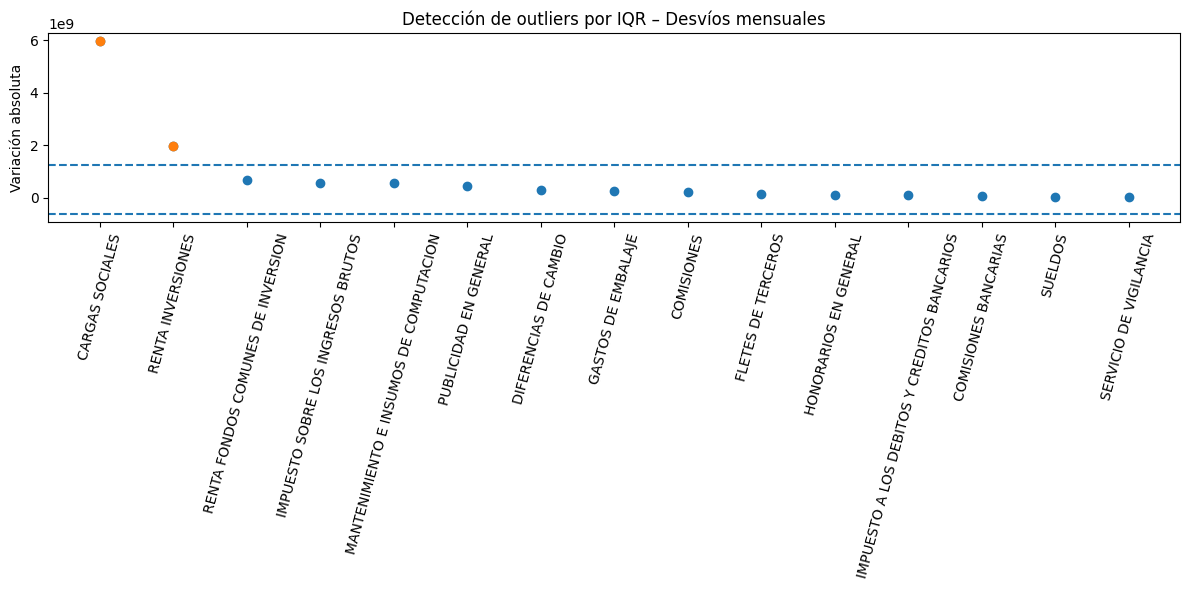

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter general
ax.scatter(
    df_iqr["nombre_cuenta"],
    df_iqr["variacion_abs_val"]
)

# Destacar outliers
df_out = df_iqr[df_iqr["outlier_iqr"]]

ax.scatter(
    df_out["nombre_cuenta"],
    df_out["variacion_abs_val"]
)

# Líneas de corte IQR
ax.axhline(limite_superior, linestyle="--")
ax.axhline(limite_inferior, linestyle="--")

ax.set_ylabel("Variación absoluta")
ax.set_title("Detección de outliers por IQR – Desvíos mensuales")
ax.tick_params(axis="x", rotation=75)

plt.tight_layout()
plt.show()


### Etapa B.4 - Seleccion de cuentas adicionales

#### En esta etapa se busca cumplir con la politica de desvios, esto implica que, en caso de que las outliers no justifiquen los desvios mensuales absolutos hasta que éste no supere el %20, se procede a seleccionar las cuentas significativas y que explican el gasto del periodo (cuentas A - pareto) con mayores desvios, hasta cumplir con el umbral establecido.

In [27]:
#Variables para calcular el umbral del 20%
desvio_total = df_comp["variacion_abs"].abs().sum()
desvio_outliers = df_iqr.loc[df_iqr["outlier_iqr"] == True, "variacion_abs_val"].sum()
desvio_residual = desvio_total - desvio_outliers
politica_desvio = df_comp["importe_abs_ant"].sum() * 0.20
gasto_total_ant = df_comp["importe_abs_ant"].sum()

In [28]:
#Datasets con las cuentas con desvíos absolutos significativos y sin tener en cuenta las outliers
df_politica = df_iqr[(df_iqr["outlier_iqr"] == False)]
df_politica

,cod_cuenta,nombre_cuenta,periodo_act,importe_act,importe_abs_act,periodo_ant,importe_ant,importe_abs_ant,variacion_abs,variacion_pct,impacto_total,flag_alerta,variacion_abs_val,outlier_iqr
2,6185,RENTA FONDOS COMUNES DE INVERSION,07/2024,"-321,109,079.28","878,913,282.16",06/2024,"-278,902,101.44","1,536,443,940.28","-657,530,658.12",-42.80,3.99,True,"657,530,658.12",False
3,6108,IMPUESTO SOBRE LOS INGRESOS BRUTOS,07/2024,"1,978,835,823.38","1,978,835,823.38",06/2024,"1,403,324,990.14","1,403,324,990.14","575,510,833.24",41.01,3.50,True,"575,510,833.24",False
4,6074,MANTENIMIENTO E INSUMOS DE COMPUTACION,07/2024,"-90,510,696.33","802,153,632.69",06/2024,"206,468,373.20","256,794,956.76","545,358,675.93",212.37,3.31,True,"545,358,675.93",False
5,6101,PUBLICIDAD EN GENERAL,07/2024,"1,278,549,299.43","1,282,642,747.21",06/2024,"800,335,811.09","838,461,738.77","444,181,008.44",52.98,2.70,True,"444,181,008.44",False
6,6148,DIFERENCIAS DE CAMBIO,07/2024,"42,826,060.98","3,152,655,238.16",06/2024,"196,061,768.31","2,864,600,433.81","288,054,804.35",10.06,1.75,False,"288,054,804.35",False
7,6024,GASTOS DE EMBALAJE,07/2024,"336,671,478.10","446,992,540.30",06/2024,"186,403,961.10","212,383,856.16","234,608,684.14",110.46,1.42,True,"234,608,684.14",False
8,6140,COMISIONES,07/2024,"293,247,363.72","375,172,862.64",06/2024,"50,359,253.00","176,017,275.72","199,155,586.92",113.15,1.21,True,"199,155,586.92",False
9,6022,FLETES DE TERCEROS,07/2024,"2,356,520,178.19","4,215,386,261.45",06/2024,"1,843,550,847.04","4,370,131,903.08","-154,745,641.63",-3.54,0.94,False,"154,745,641.63",False
10,6084,HONORARIOS EN GENERAL,07/2024,"729,871,778.47","783,875,873.41",06/2024,"593,303,210.80","685,995,901.68","97,879,971.73",14.27,0.59,False,"97,879,971.73",False
11,6111,IMPUESTO A LOS DEBITOS Y CREDITOS BANCARIOS,07/2024,"325,801,171.30","977,403,513.90",06/2024,"233,983,725.37","1,065,904,325.37","-88,500,811.47",-8.30,0.54,False,"88,500,811.47",False


In [29]:
df_politica = df_politica.sort_values("variacion_abs_val",ascending=False).reset_index(drop=True)

In [30]:
#Creacion de la columna de desvio absoluto acumulado
df_politica["desvio_acumulado"] = df_politica["variacion_abs_val"].cumsum()
df_politica

,cod_cuenta,nombre_cuenta,periodo_act,importe_act,importe_abs_act,periodo_ant,importe_ant,importe_abs_ant,variacion_abs,variacion_pct,impacto_total,flag_alerta,variacion_abs_val,outlier_iqr,desvio_acumulado
0,6185,RENTA FONDOS COMUNES DE INVERSION,07/2024,"-321,109,079.28","878,913,282.16",06/2024,"-278,902,101.44","1,536,443,940.28","-657,530,658.12",-42.80,3.99,True,"657,530,658.12",False,"657,530,658.12"
1,6108,IMPUESTO SOBRE LOS INGRESOS BRUTOS,07/2024,"1,978,835,823.38","1,978,835,823.38",06/2024,"1,403,324,990.14","1,403,324,990.14","575,510,833.24",41.01,3.50,True,"575,510,833.24",False,"1,233,041,491.36"
2,6074,MANTENIMIENTO E INSUMOS DE COMPUTACION,07/2024,"-90,510,696.33","802,153,632.69",06/2024,"206,468,373.20","256,794,956.76","545,358,675.93",212.37,3.31,True,"545,358,675.93",False,"1,778,400,167.29"
3,6101,PUBLICIDAD EN GENERAL,07/2024,"1,278,549,299.43","1,282,642,747.21",06/2024,"800,335,811.09","838,461,738.77","444,181,008.44",52.98,2.70,True,"444,181,008.44",False,"2,222,581,175.73"
4,6148,DIFERENCIAS DE CAMBIO,07/2024,"42,826,060.98","3,152,655,238.16",06/2024,"196,061,768.31","2,864,600,433.81","288,054,804.35",10.06,1.75,False,"288,054,804.35",False,"2,510,635,980.08"
5,6024,GASTOS DE EMBALAJE,07/2024,"336,671,478.10","446,992,540.30",06/2024,"186,403,961.10","212,383,856.16","234,608,684.14",110.46,1.42,True,"234,608,684.14",False,"2,745,244,664.22"
6,6140,COMISIONES,07/2024,"293,247,363.72","375,172,862.64",06/2024,"50,359,253.00","176,017,275.72","199,155,586.92",113.15,1.21,True,"199,155,586.92",False,"2,944,400,251.14"
7,6022,FLETES DE TERCEROS,07/2024,"2,356,520,178.19","4,215,386,261.45",06/2024,"1,843,550,847.04","4,370,131,903.08","-154,745,641.63",-3.54,0.94,False,"154,745,641.63",False,"3,099,145,892.77"
8,6084,HONORARIOS EN GENERAL,07/2024,"729,871,778.47","783,875,873.41",06/2024,"593,303,210.80","685,995,901.68","97,879,971.73",14.27,0.59,False,"97,879,971.73",False,"3,197,025,864.50"
9,6111,IMPUESTO A LOS DEBITOS Y CREDITOS BANCARIOS,07/2024,"325,801,171.30","977,403,513.90",06/2024,"233,983,725.37","1,065,904,325.37","-88,500,811.47",-8.30,0.54,False,"88,500,811.47",False,"3,285,526,675.97"


In [31]:
#Seleccion de las cuentas que se deben justificar para cumplir con la politica
df_politica["¿Justificar?"] = (desvio_outliers + df_politica["desvio_acumulado"]) <= (desvio_total - politica_desvio)
df_politica

,cod_cuenta,nombre_cuenta,periodo_act,importe_act,importe_abs_act,periodo_ant,importe_ant,importe_abs_ant,variacion_abs,variacion_pct,impacto_total,flag_alerta,variacion_abs_val,outlier_iqr,desvio_acumulado,¿Justificar?
0,6185,RENTA FONDOS COMUNES DE INVERSION,07/2024,"-321,109,079.28","878,913,282.16",06/2024,"-278,902,101.44","1,536,443,940.28","-657,530,658.12",-42.80,3.99,True,"657,530,658.12",False,"657,530,658.12",True
1,6108,IMPUESTO SOBRE LOS INGRESOS BRUTOS,07/2024,"1,978,835,823.38","1,978,835,823.38",06/2024,"1,403,324,990.14","1,403,324,990.14","575,510,833.24",41.01,3.50,True,"575,510,833.24",False,"1,233,041,491.36",True
2,6074,MANTENIMIENTO E INSUMOS DE COMPUTACION,07/2024,"-90,510,696.33","802,153,632.69",06/2024,"206,468,373.20","256,794,956.76","545,358,675.93",212.37,3.31,True,"545,358,675.93",False,"1,778,400,167.29",False
3,6101,PUBLICIDAD EN GENERAL,07/2024,"1,278,549,299.43","1,282,642,747.21",06/2024,"800,335,811.09","838,461,738.77","444,181,008.44",52.98,2.70,True,"444,181,008.44",False,"2,222,581,175.73",False
4,6148,DIFERENCIAS DE CAMBIO,07/2024,"42,826,060.98","3,152,655,238.16",06/2024,"196,061,768.31","2,864,600,433.81","288,054,804.35",10.06,1.75,False,"288,054,804.35",False,"2,510,635,980.08",False
5,6024,GASTOS DE EMBALAJE,07/2024,"336,671,478.10","446,992,540.30",06/2024,"186,403,961.10","212,383,856.16","234,608,684.14",110.46,1.42,True,"234,608,684.14",False,"2,745,244,664.22",False
6,6140,COMISIONES,07/2024,"293,247,363.72","375,172,862.64",06/2024,"50,359,253.00","176,017,275.72","199,155,586.92",113.15,1.21,True,"199,155,586.92",False,"2,944,400,251.14",False
7,6022,FLETES DE TERCEROS,07/2024,"2,356,520,178.19","4,215,386,261.45",06/2024,"1,843,550,847.04","4,370,131,903.08","-154,745,641.63",-3.54,0.94,False,"154,745,641.63",False,"3,099,145,892.77",False
8,6084,HONORARIOS EN GENERAL,07/2024,"729,871,778.47","783,875,873.41",06/2024,"593,303,210.80","685,995,901.68","97,879,971.73",14.27,0.59,False,"97,879,971.73",False,"3,197,025,864.50",False
9,6111,IMPUESTO A LOS DEBITOS Y CREDITOS BANCARIOS,07/2024,"325,801,171.30","977,403,513.90",06/2024,"233,983,725.37","1,065,904,325.37","-88,500,811.47",-8.30,0.54,False,"88,500,811.47",False,"3,285,526,675.97",False


### Descarga de Datasets para alimentar el reporte en Power Bi

In [32]:
ruta_outputs = ROOT / "outputs"

df_pareto.to_csv(ruta_outputs/"pareto_mes.csv", index=False)
df_comp.to_csv(ruta_outputs/"desvios_mes_total.csv", index=False)
df_comp_A.to_csv(ruta_outputs/"desvios_mes_A.csv", index=False)
df_iqr.to_csv(ruta_outputs/"outliers_iqr.csv", index=False)
df_politica.to_csv(ruta_outputs/"cuentas_adicionales.csv", index=False)